In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
trip_temps = calc_temps('2017-08-01', '2017-08-07')
trip_temps

[(72.0, 79.25, 83.0)]

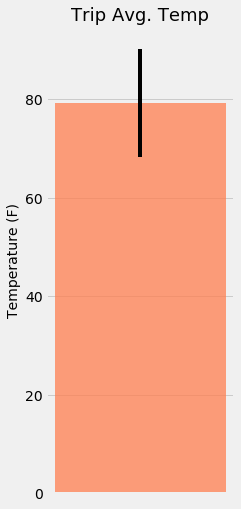

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_axis = 0 
y_axis = trip_temps[0][1]
peak_diff = trip_temps[0][2] - trip_temps[0][0]

plt.figure(figsize = (3,8))
plt.bar(x_axis, y_axis, yerr=peak_diff, color = 'coral', alpha = 0.75)
plt.title('Trip Avg. Temp', size = 18)
plt.ylabel('Temperature (F)', size = 14)
plt.xticks([])
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-08-01'
end_date = '2016-08-07'

rainfall_station = session.query(func.sum(measurement.prcp), station.name, station.latitude, station.longitude, station.elevation).\
filter(measurement.date >= start_date, measurement.date <= end_date).\
join(station, station.station == measurement.station).\
group_by(measurement.station).\
order_by(func.sum(measurement.prcp).desc()).all()

rainfall_station

[(6.019999999999998, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (4.6499999999999995, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (3.59, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (1.3000000000000003, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (1.03, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.5700000000000001, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.18, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

### Daily Temperature Normals

In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates 
# Strip off the year and save a list of strings in the format %m-%d
start_date1 = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_date1 = dt.datetime.strptime(end_date, '%Y-%m-%d')

date_range = []
for x in range((end_date1 - start_date1).days+1):
    date = start_date1 + dt.timedelta(x)
    date_range.append(str(dt.datetime.strftime(date,'%m-%d')))

date_range

# Use the `daily_normals` function to calculate the normals for each date string and append the results to a list called `normals`.
normals = []
for date in date_range:
    daily_norms_aug = daily_normals(date)
    normals.append(daily_norms_aug)
    
normals


[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(columns=['Min Temp', 'Avg. Temp', 'Max Temp'])

for x in normals:
    normals_list = list(np.ravel(x))
    daily_norms_df = daily_norms_df.append({'Min Temp': normals_list[0], 
                                            'Avg. Temp': normals_list[1], 
                                            'Max Temp': normals_list[2]}, ignore_index = True)

daily_norms_df['Date'] = date_range
daily_norms_df.set_index('Date', inplace = True)
daily_norms_df

,Min Temp,Avg. Temp,Max Temp
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


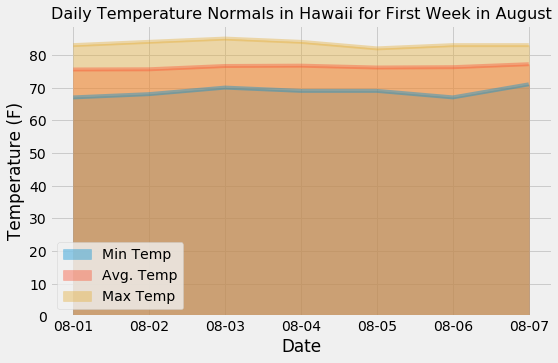

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind = 'area', stacked = False, alpha = 0.4, figsize = (8,5))
plt.legend(loc = 'best')
plt.title('Daily Temperature Normals in Hawaii for First Week in August', size = 16)
plt.ylabel('Temperature (F)')
plt.show()

## Close Session

In [17]:
session.close()